# Validation of the Kolmorow Flow solver vis spectrum comparison

The spectrum of the Kolmogow flow at specific Reynolds numbers is known.

This notebook is a Work-in-Progress. So far, I believe that I only considered
the enstrophy spectrum (of the vorticity). Probably, I have to extract the
velocity components out of the vorticity and compute an energy spectrum with
them to correctly compare with, e.g., the Kochkov et al. paper.

In [38]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import exponax as ex

In [3]:
kolm_stepper = ex.stepper.KolmogorovFlowVorticity(
    2,
    2 * jnp.pi,
    200,
    0.01,
    diffusivity=0.005,
)

2024-04-10 07:45:14.509656: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.52). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
ic = ex.ic.DiffusedNoise(2)(200, key=jax.random.PRNGKey(0))

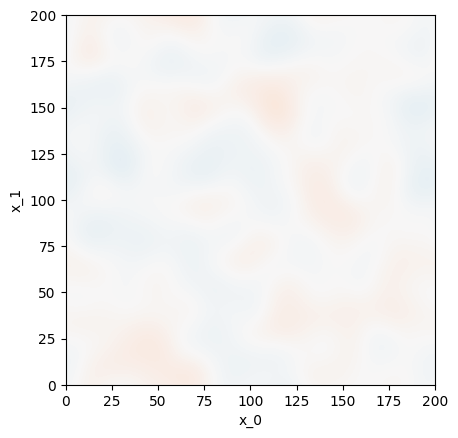

In [5]:
ex.viz.plot_state_2d(ic, vlim=(-1, 1))

In [6]:
# Warmup
ic = ex.repeat(kolm_stepper, 30_000)(ic)

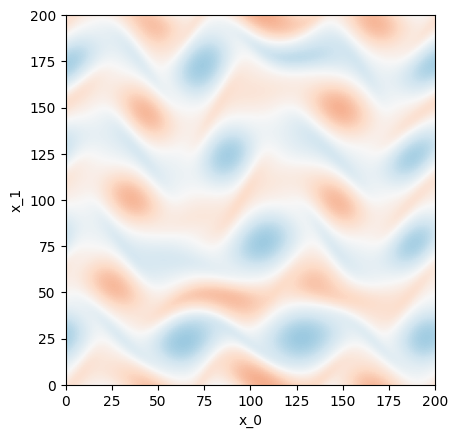

In [8]:
ex.viz.plot_state_2d(ic, vlim=(-10, 10))

In [9]:
# Create a trajectory for time-averaged statistics
trj = ex.rollout(kolm_stepper, 5000, include_init=True)(ic)
trj.shape

(5001, 1, 200, 200)

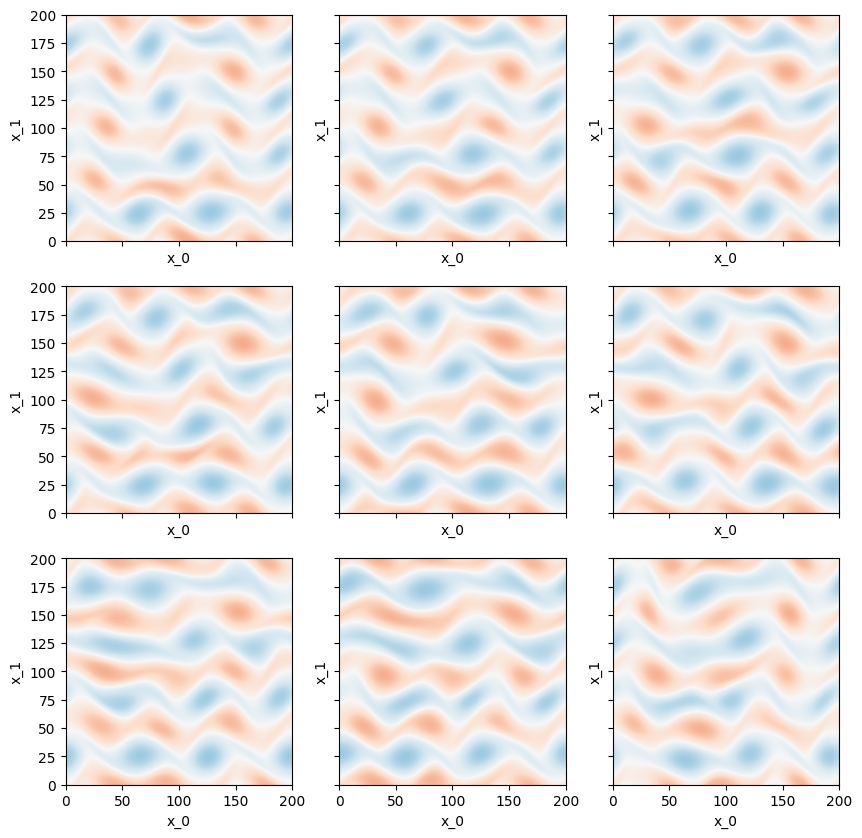

In [15]:
ex.viz.plot_state_2d_facet(trj[::500], facet_over_channels=False, vlim=(-10, 10));

In [10]:
# Transform the spatial dimensions into Fourier space (fft2 per default operates
# over last two axes)
trj_hat = jnp.fft.rfft2(trj)

In [20]:
200 // 2 + 1

101

Text(0.5, 1.0, 'Log10 of the amplitude of Fourier coefficients\nafter warmup')

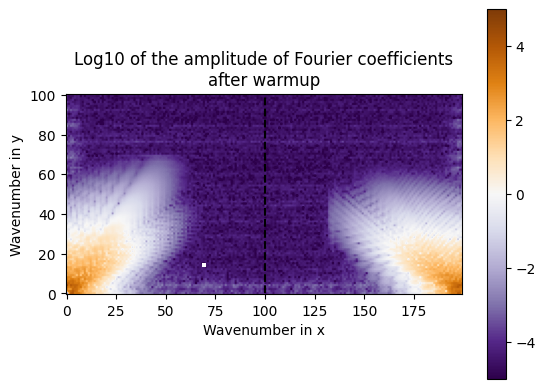

In [29]:
plt.imshow(
    jnp.log10(jnp.abs(trj_hat[0][0])).T, origin="lower", vmin=-5, vmax=5, cmap="PuOr_r"
)
plt.vlines(100, 0, 100, color="k", linestyle="--")
plt.colorbar()
plt.xlabel("Wavenumber in x")
plt.ylabel("Wavenumber in y")
plt.title("Log10 of the amplitude of Fourier coefficients\nafter warmup")

In [26]:
time_averaged_abs_trj_hat = jnp.mean(jnp.abs(trj_hat), axis=0)

Text(0.5, 1.0, 'Log10 of the amplitude of Fourier coefficients\naveraged over trajectory')

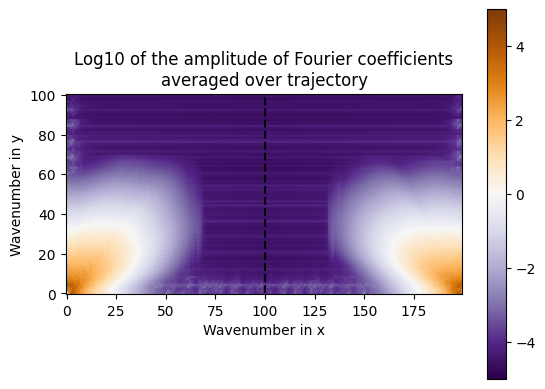

In [31]:
plt.imshow(
    jnp.log10(time_averaged_abs_trj_hat[0]).T,
    origin="lower",
    vmin=-5,
    vmax=5,
    cmap="PuOr_r",
)
plt.vlines(100, 0, 100, color="k", linestyle="--")
plt.colorbar()
plt.xlabel("Wavenumber in x")
plt.ylabel("Wavenumber in y")
plt.title("Log10 of the amplitude of Fourier coefficients\naveraged over trajectory")

In [32]:
wavenumbers = ex._spectral.build_scaled_wavenumbers(2, 2 * jnp.pi, 200)

In [33]:
wavenumbers.shape

(2, 200, 101)

In [34]:
wavenumbers_norm = jnp.linalg.norm(wavenumbers, axis=0)

In [35]:
wavenumbers_norm.shape

(200, 101)

In [36]:
wavenumbers_norm.flatten()

Array([  0.     ,   1.     ,   2.     , ...,  98.0051 ,  99.00505,
       100.005  ], dtype=float32)

In [46]:
data = pd.DataFrame(
    {
        "wavenumber": wavenumbers_norm.flatten(),
        "energy": (time_averaged_abs_trj_hat**2).flatten(),
    }
)

In [41]:
import seaborn as sns

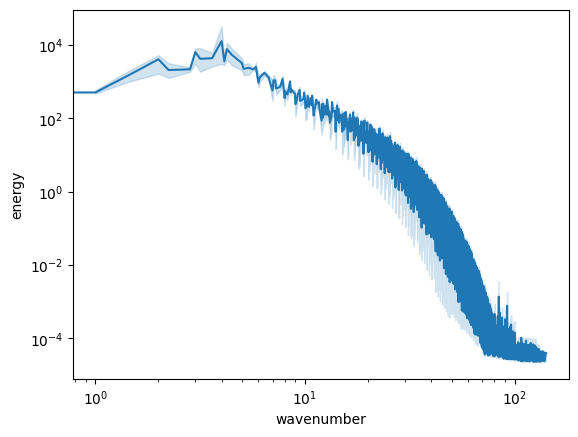

In [42]:
sns.lineplot(data=data, x="wavenumber", y="energy")
plt.yscale("log")
plt.xscale("log")

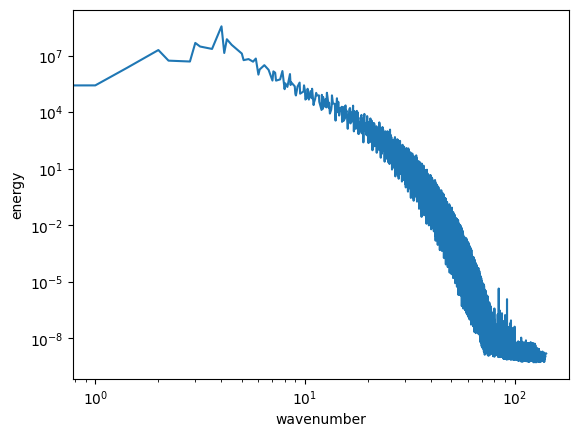

In [47]:
sns.lineplot(data=data, x="wavenumber", y="energy", errorbar=None)
plt.yscale("log")
plt.xscale("log")

In [48]:
data["scaled_energy"] = data["energy"] * data["wavenumber"] ** 5

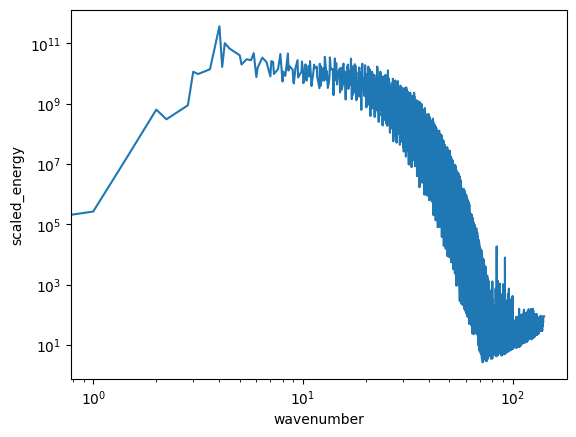

In [49]:
sns.lineplot(data=data, x="wavenumber", y="scaled_energy", errorbar=None)
plt.yscale("log")
plt.xscale("log")